In [ ]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.layers import LSTM, Dense
import IPython.display as ipd

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
audio_files_a = "/content/drive/MyDrive/IEEE/IoT Stethescope/heart_sounds/"
set_a_csv = pd.read_csv("/content/drive/MyDrive/IEEE/IoT Stethescope/heart_sounds/set_a.csv")
set_a_csv.head()

In [ ]:
audio_files_b = "/content/drive/MyDrive/IEEE/IoT Stethescope/heart_sounds/set_b"
set_b_csv = pd.read_csv("/content/drive/MyDrive/IEEE/IoT Stethescope/heart_sounds/set_b.csv")
set_b_csv.head()

In [ ]:
frames = [set_a_csv, set_b_csv]
train_ab=pd.concat(frames)
train_ab.describe()

In [ ]:
nab_classes=train_ab.label.unique()

print("Number of training examples=", train_ab.shape[0], "  Number of classes=", len(nab_classes))
print (nab_classes)

In [ ]:
na_classes = set_a_csv.label.unique()
print("Number of training examples=", set_a_csv.shape[0], "  Number of classes=", len(na_classes))
print (na_classes)

In [ ]:

category_group = train_ab.groupby(['label','dataset']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,5))
plot.set_xlabel("Category")
plot.set_ylabel("Samples Count");

print('Min samples per category = ', min(train_ab.label.value_counts()))
print('Max samples per category = ', max(train_ab.label.value_counts()))

In [ ]:
audio1 = audio_files_a + "set_a/artifact__201012172012.wav"
y, t = librosa.load(audio1, sr = 22000)
librosa.display.waveplot(y, t, alpha=1)
plt.xlabel("Time (in seconds)")
plt.ylabel("Amplitude")
plt.title("Waveform")

In [ ]:

ipd.Audio(audio1)

In [ ]:
audio1_murmur = audio_files_a + "set_a/artifact__201012172012.wav"
y, t = librosa.load(audio1_murmur, sr = 22000)
librosa.display.waveplot(y, t, alpha=1)
plt.xlabel("Time (in seconds)")
plt.ylabel("Amplitude")
plt.title("Waveform")

In [ ]:
import os
import wave
with wave.open("/content/drive/MyDrive/IEEE/IoT Stethescope/heart_sounds/set_a/Aunlabelledtest__201101152256.wav", "rb") as wave_file:
    frame_rate = wave_file.getframerate()
    print(frame_rate)

In [ ]:
import wave
wav = wave.open(audio1)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

MFCC

In [ ]:
y, sr = librosa.load(audio1)
mfccs = librosa.feature.mfcc(y=y, sr=sr)
print (mfccs)


In [ ]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
log_S=librosa.feature.mfcc(S=librosa.power_to_db(S))
print (log_S)

In [ ]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
plt.figure(figsize=(12, 3))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('Mel-frequency cepstral coefficients (MFCCs)')
plt.tight_layout()

In [ ]:
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
librosa.frames_to_time(onset_frames, sr=sr)

In [ ]:
o_env = librosa.onset.onset_strength(y, sr=sr)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

In [ ]:
D = np.abs(librosa.stft(y))
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),x_axis='time', y_axis='log')
plt.title('Power spectrogram')
plt.subplot(2, 1, 2, sharex=ax1)

plt.plot(times, o_env, label='Onset strength')
plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,linestyle='--', label='Onsets')
plt.axis('tight')
plt.legend(frameon=True, framealpha=0.75)

#Loading The Data

In [ ]:
print("Number of training examples=", train_ab.shape[0], "  Number of classes=", len(train_ab.label.unique()))

In [ ]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5

# get audio data without padding highest qualify audio
def load_file_data_without_change(folder,file_names, duration=3, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction if not use 'kaiser_best' changed it here
            X, sr = librosa.load( sound_file, res_type='kaiser_best') 
            dur = librosa.get_duration(y=X, sr=sr)
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=30).T,axis=0) 
        except Exception as e:
            print("Error encountered while parsing file: ", file)
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data


# get audio data with a fix padding may also chop off some file
def load_file_data (folder,file_names, duration=12, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, sr=sr, duration=duration,res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                print ("fixing audio lenght :", file_name)
                y = librosa.util.fix_length(X, input_length)                
            #normalized raw audio 
            # y = audio_norm(y)            
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=30).T,axis=0)             
        except Exception as e:
            print("Error encountered while parsing file: ", file)        
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Map label text to integer
CLASSES = ['artifact','murmur','normal']
# {'artifact': 0, 'murmur': 1, 'normal': 3}
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
# map integer to label text
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

In [ ]:

import os, fnmatch

MAX_SOUND_CLIP_DURATION=12 
A_folder=audio_files_a+'/set_a/'
# set-a
A_artifact_files = fnmatch.filter(os.listdir(audio_files_a+'/set_a'), 'artifact*.wav')
A_artifact_sounds = load_file_data(folder=A_folder,file_names=A_artifact_files, duration=MAX_SOUND_CLIP_DURATION)
A_artifact_labels = [0 for items in A_artifact_files]

A_normal_files = fnmatch.filter(os.listdir(audio_files_a+'/set_a'), 'normal*.wav')
A_normal_sounds = load_file_data(folder=A_folder,file_names=A_normal_files, duration=MAX_SOUND_CLIP_DURATION)
A_normal_labels = [2 for items in A_normal_sounds]

A_extrahls_files = fnmatch.filter(os.listdir(audio_files_a+'/set_a'), 'extrahls*.wav')
A_extrahls_sounds = load_file_data(folder=A_folder,file_names=A_extrahls_files, duration=MAX_SOUND_CLIP_DURATION)
A_extrahls_labels = [1 for items in A_extrahls_sounds]

A_murmur_files = fnmatch.filter(os.listdir(audio_files_a+'/set_a'), 'murmur*.wav')
A_murmur_sounds = load_file_data(folder=A_folder,file_names=A_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
A_murmur_labels = [1 for items in A_murmur_files]

# test files
A_unlabelledtest_files = fnmatch.filter(os.listdir(audio_files_a+'/set_a'), 'Aunlabelledtest*.wav')
A_unlabelledtest_sounds = load_file_data(folder=A_folder,file_names=A_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
A_unlabelledtest_labels = [-1 for items in A_unlabelledtest_sounds]

print ("loaded dataset-a")

load file  /content/drive/MyDrive/IEEE/IoT Stethescope/heart_sounds//set_a/artifact__201105040918.wav
fixing audio lenght : artifact__201105040918.wav
load file  /content/drive/MyDrive/IEEE/IoT Stethescope/heart_sounds//set_a/artifact__201105280851.wav
fixing audio lenght : artifact__201105280851.wav
load file  /content/drive/MyDrive/IEEE/IoT Stethescope/heart_sounds//set_a/artifact__201106021541.wav
fixing audio lenght : artifact__201106021541.wav
load file  /content/drive/MyDrive/IEEE/IoT Stethescope/heart_sounds//set_a/artifact__201105041959.wav
fixing audio lenght : artifact__201105041959.wav
load file  /content/drive/MyDrive/IEEE/IoT Stethescope/heart_sounds//set_a/artifact__201105051017.wav
fixing audio lenght : artifact__201105051017.wav
load file  /content/drive/MyDrive/IEEE/IoT Stethescope/heart_sounds//set_a/artifact__201105060108.wav
fixing audio lenght : artifact__201105060108.wav
load file  /content/drive/MyDrive/IEEE/IoT Stethescope/heart_sounds//set_a/artifact__201012172

In [ ]:
%%time
# load dataset-b, keep them separate for testing purpose 
B_folder=audio_files_a+'/set_b/'
# set-b
B_normal_files = fnmatch.filter(os.listdir(audio_files_a+'/set_b'), 'normal*.wav')  # include noisy files
B_normal_sounds = load_file_data(folder=B_folder,file_names=B_normal_files, duration=MAX_SOUND_CLIP_DURATION)
B_normal_labels = [2 for items in B_normal_sounds]

B_murmur_files = fnmatch.filter(os.listdir(audio_files_a+'/set_b'), 'murmur*.wav')  # include noisy files
B_murmur_sounds = load_file_data(folder=B_folder,file_names=B_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
B_murmur_labels = [1 for items in B_murmur_files]

B_extrastole_files = fnmatch.filter(os.listdir(audio_files_a+'/set_b'), 'extrastole*.wav')
B_extrastole_sounds = load_file_data(folder=B_folder,file_names=B_extrastole_files, duration=MAX_SOUND_CLIP_DURATION)
B_extrastole_labels = [1 for items in B_extrastole_files]

#test files
B_unlabelledtest_files = fnmatch.filter(os.listdir(audio_files_a+'/set_b'), 'Bunlabelledtest*.wav')
B_unlabelledtest_sounds = load_file_data(folder=B_folder,file_names=B_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
B_unlabelledtest_labels = [-1 for items in B_unlabelledtest_sounds]
print ("loaded dataset-b")

load file  /content/drive/MyDrive/IEEE/IoT Stethescope/heart_sounds//set_b/normal__113_1306244002866_D.wav
fixing audio lenght : normal__113_1306244002866_D.wav
load file  /content/drive/MyDrive/IEEE/IoT Stethescope/heart_sounds//set_b/normal__117_1306262456650_B.wav
fixing audio lenght : normal__117_1306262456650_B.wav
load file  /content/drive/MyDrive/IEEE/IoT Stethescope/heart_sounds//set_b/normal__107_1305654946865_C1.wav
fixing audio lenght : normal__107_1305654946865_C1.wav
load file  /content/drive/MyDrive/IEEE/IoT Stethescope/heart_sounds//set_b/normal__106_1306776721273_B1.wav
fixing audio lenght : normal__106_1306776721273_B1.wav
load file  /content/drive/MyDrive/IEEE/IoT Stethescope/heart_sounds//set_b/normal__127_1306764300147_C1.wav
fixing audio lenght : normal__127_1306764300147_C1.wav
load file  /content/drive/MyDrive/IEEE/IoT Stethescope/heart_sounds//set_b/normal__126_1306777102824_D.wav
fixing audio lenght : normal__126_1306777102824_D.wav
load file  /content/drive/My

In [ ]:
x_data = np.concatenate((A_artifact_sounds, A_normal_sounds,A_extrahls_sounds,A_murmur_sounds, B_normal_sounds,B_murmur_sounds,B_extrastole_sounds))

y_data = np.concatenate((A_artifact_labels, A_normal_labels,A_extrahls_labels,A_murmur_labels,
                         B_normal_labels,B_murmur_labels,B_extrastole_labels))

test_x = np.concatenate((A_unlabelledtest_sounds,B_unlabelledtest_sounds))
test_y = np.concatenate((A_unlabelledtest_labels,B_unlabelledtest_labels))

print ("combined training data record: ",len(y_data), len(test_y))

combined training data record:  585 247


In [ ]:
import keras
seed = 1000
# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.9, random_state=seed, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=seed, shuffle=True)

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(keras.utils.to_categorical(y_test, len(CLASSES)))
y_val = np.array(keras.utils.to_categorical(y_val, len(CLASSES)))
test_y=np.array(keras.utils.to_categorical(test_y, len(CLASSES))) 

In [ ]:
print ("label shape: ", y_data.shape)
print ("data size of the array: : %s" % y_data.size)
print ("length of one array element in bytes: ", y_data.itemsize)
print ("total bytes consumed by the elements of the array: ", y_data.nbytes)
print (y_data[1])
print ("")
print ("audio data shape: ", x_data.shape)
print ("data size of the array: : %s" % x_data.size)
print ("length of one array element in bytes: ", x_data.itemsize)
print ("total bytes consumed by the elements of the array: ", x_data.nbytes)
#print (x_data[1])
print ("")
print ("training data shape: ", x_train.shape)
print ("training label shape: ", y_train.shape)
print ("")
print ("validation data shape: ", x_val.shape)
print ("validation label shape: ", y_val.shape)
print ("")
print ("test data shape: ", x_test.shape)
print ("test label shape: ", y_test.shape)

label shape:  (585,)
data size of the array: : 585
length of one array element in bytes:  8
total bytes consumed by the elements of the array:  4680
0

audio data shape:  (585, 40, 1)
data size of the array: : 23400
length of one array element in bytes:  4
total bytes consumed by the elements of the array:  93600

training data shape:  (473, 40, 1)
training label shape:  (473, 3)

validation data shape:  (53, 40, 1)
validation label shape:  (53, 3)

test data shape:  (59, 40, 1)
test label shape:  (59, 3)


#Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import SimpleRNN
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from keras.utils import np_utils
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools

In [ ]:
print('Build LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=128, dropout=0.20, recurrent_dropout=0.20, return_sequences=True,input_shape = (40,1)))
#model.add(LSTM(units=128, dropout=0.20, recurrent_dropout=0.20, return_sequences=True))
model.add(LSTM(units=64, dropout=0.20, recurrent_dropout=0.20, return_sequences=False))
model.add(Dense(len(CLASSES), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[ 'accuracy'])
model.summary()

Build LSTM RNN model ...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 40, 128)           66560     
                                                                 
 lstm_10 (LSTM)              (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 116,163
Trainable params: 116,163
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
# saved model checkpoint file
best_model_file="./best_model_trained.hdf5"
#train_model_file=file_path+"/checkpoints/weights.best_{epoch:02d}-{loss:.2f}.hdf5"
MAX_PATIENT=12
MAX_EPOCHS=100
MAX_BATCH=32

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1), ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

# training
history=model.fit(x_train, y_train, 
                  batch_size=MAX_BATCH, 
                  
                  epochs=MAX_EPOCHS,
                  verbose=0,
                  validation_data=(x_val, y_val),
                  callbacks=callback) 


Epoch 1: loss improved from inf to 0.90361, saving model to ./best_model_trained.hdf5

Epoch 2: loss improved from 0.90361 to 0.75927, saving model to ./best_model_trained.hdf5

Epoch 3: loss improved from 0.75927 to 0.70487, saving model to ./best_model_trained.hdf5

Epoch 4: loss improved from 0.70487 to 0.70261, saving model to ./best_model_trained.hdf5

Epoch 5: loss improved from 0.70261 to 0.68402, saving model to ./best_model_trained.hdf5

Epoch 6: loss improved from 0.68402 to 0.65688, saving model to ./best_model_trained.hdf5

Epoch 7: loss did not improve from 0.65688

Epoch 8: loss improved from 0.65688 to 0.64892, saving model to ./best_model_trained.hdf5

Epoch 9: loss improved from 0.64892 to 0.64779, saving model to ./best_model_trained.hdf5

Epoch 10: loss did not improve from 0.64779

Epoch 11: loss improved from 0.64779 to 0.63000, saving model to ./best_model_trained.hdf5

Epoch 12: loss improved from 0.63000 to 0.61993, saving model to ./best_model_trained.hdf5

Ep

In [ ]:
score = model.evaluate(x_train, y_train, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(x_test, y_test, verbose=0) 
print ("model test data score        : ",round(score[1]*100) , "%")

score = model.evaluate(x_val, y_val, verbose=0) 
print ("model validation data score  : ", round(score[1]*100), "%")

score = model.evaluate(test_x, test_y, verbose=0) 
print ("model unlabeled data score   : ", round(score[1]*100), "%")

model train data score       :  71 %
model test data score        :  69 %
model validation data score  :  79 %
model unlabeled data score   :  79 %


<Figure size 1584x720 with 0 Axes>

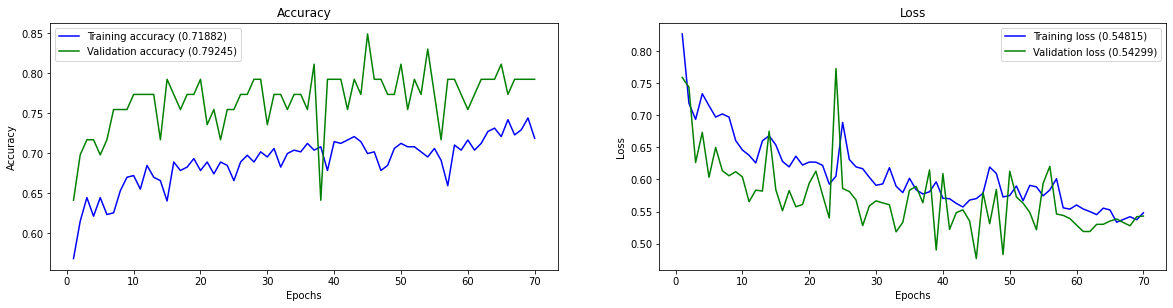

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    plt.figure(figsize=(22,10))
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Accuracy
    plt.figure(221, figsize=(20,10))
    ## Accuracy
    # plt.figure(2,figsize=(14,5))
    plt.subplot(221, title='Accuracy')
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    ## Loss
    plt.subplot(222, title='Loss')
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# plot history
plot_history(history)